In [ ]:
# AI Image Detector
# Cameron Kelly

In [ ]:
# Getting Data
# https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset/data?select=train_data
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'ai-vs-human-generated-dataset' dataset.
Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset
['test_data_v2', 'train.csv', 'test.csv', 'train_data']


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Simple Model Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, BatchNormalization, GlobalAveragePooling2D

from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

from google.colab import drive
drive.mount('/content/drive')

# For Heat Map
from tensorflow.keras.preprocessing import image
import cv2
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Preparing Data

seed = 42

train_csv = os.path.join(path, "train.csv")
train_img_folder = os.path.join(path, "train_data")

df_train = pd.read_csv(train_csv)
df_train["filepath"] = df_train["file_name"].apply(lambda x: os.path.join(path, x))

# 70/10/20 Training/Validation/Testing Split
X_val, X_test, y_val, y_test = train_test_split(
    df_train["filepath"], df_train["label"],
    test_size = 0.2, stratify = df_train["label"], random_state = seed
)

X_train, X_val, y_train, y_val = train_test_split(
    X_val, y_val,
    test_size = 0.125, stratify = y_val, random_state = seed
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 55965
Validation size: 7995
Test size: 15990


In [ ]:
# Preprocessing Data

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img, label

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls = tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls = tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
test_ds = test_ds.map(load_and_preprocess)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

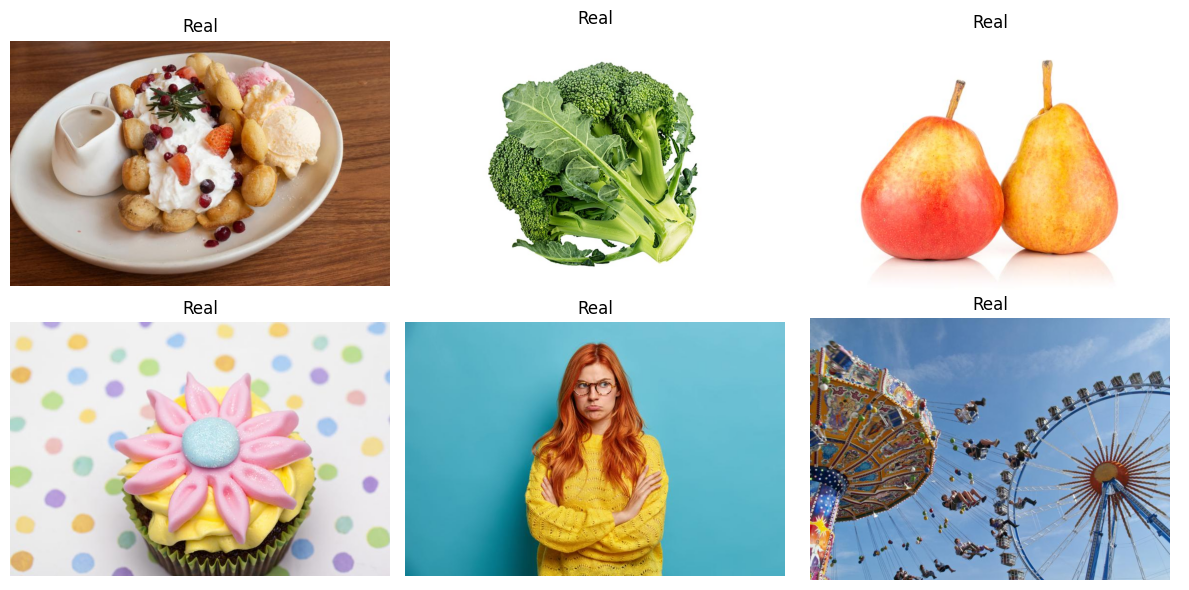

In [ ]:
# Visualizing A Few Images

# 0 = Real, 1 = AI-Generated

import matplotlib.image as mpimg
import random

label_dict = {0: "Real", 1: "AI-generated"}

sample_indices = random.sample(range(len(X_train)), 6)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(sample_indices):
    img_path = X_train.iloc[idx]
    label = y_train.iloc[idx]

    img = mpimg.imread(img_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(str(label_dict[label]))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Baseline Model (Simple CNN)

simple_model = Sequential([
    Rescaling(1./255, input_shape = (224, 224, 3)),

    # First Convolution Block
    Conv2D(32, (3, 3), activation = "relu"),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation = "relu"),
    MaxPooling2D(2,2),

    # Second Convolution Block
    (64, (3, 3), activation = "relu"),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D(2,2),

    # Third Convolution Block
    Conv2D(128, (3, 3), activation = "relu"),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),

    # Fourth Convolution Block
    Conv2D(256, (3, 3), activation = "relu"),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),

    # Global Pooling
    GlobalAveragePooling2D(),

    # Classifier
    Dense(512, activation = "relu"),
    Dropout(0.5),
    Dense(256, activation = "relu"),
    Dropout(0.3),
    Dense(1, activation = "sigmoid")
])

simple_model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Training Simple Model

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True,
    verbose = 1
)

history = simple_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
    shuffle = True,
    callbacks = [early_stop]
)

loss, accuracy = simple_model.evaluate(test_ds)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 316s 174ms/step - accuracy: 0.8580 - loss: 0.3564 - val_accuracy: 0.8009 - val_loss: 0.5594
Epoch 2/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 272s 154ms/step - accuracy: 0.9155 - loss: 0.2287 - val_accuracy: 0.7977 - val_loss: 0.5435
Epoch 3/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 272s 154ms/step - accuracy: 0.9248 - loss: 0.2025 - val_accuracy: 0.8842 - val_loss: 0.2569
Epoch 4/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 271s 154ms/step - accuracy: 0.9320 - loss: 0.1798 - val_accuracy: 0.7719 - val_loss: 0.5991
Epoch 5/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 280s 158ms/step - accuracy: 0.9397 - loss: 0.1644 - val_accuracy: 0.4687 - val_loss: 4.1260
Epoch 6/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 292s 165ms/step - accuracy: 0.9430 - loss: 0.1531 - val_accuracy: 0.5124 - val_loss: 22.8045
Epoch 7/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 283s 160ms/step - accuracy: 0.9477 - loss: 0.1422 - val_accuracy: 0.5011 - val_loss: 227.1266
Epoch 8/30
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 294s 166ms/step -

In [ ]:
# Save Simple Model
simple_model.save("/content/drive/My Drive/models/simple_model.h5")

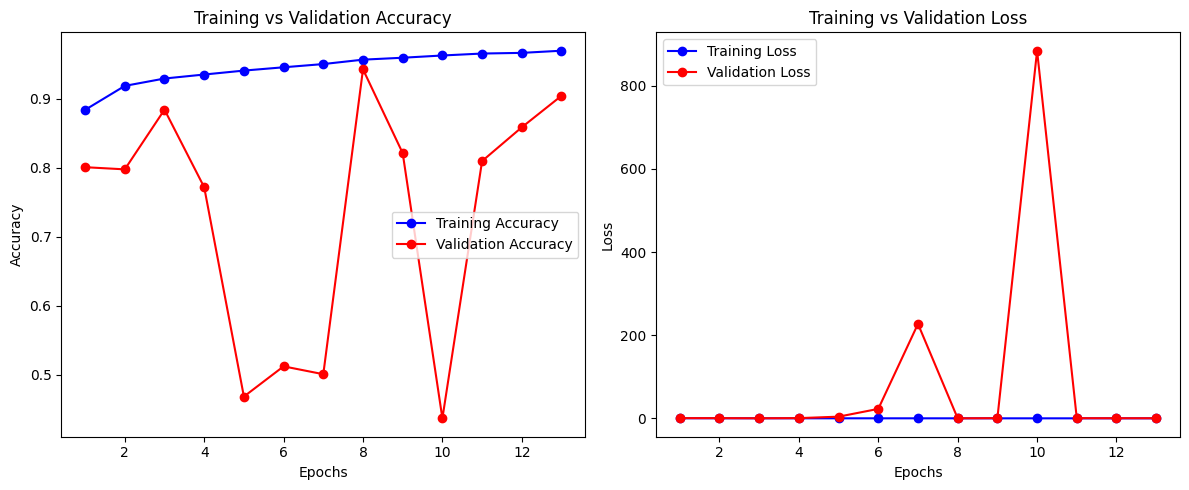

In [ ]:
# Plot Accuracy and Loss

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "bo-", label = "Training Accuracy")
plt.plot(epochs, val_acc, "ro-", label = "Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo-", label = "Training Loss")
plt.plot(epochs, val_loss, "ro-", label = "Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 117ms/step
              precision    recall  f1-score   support

        Real       0.94      0.93      0.94      7995
      AI-Gen       0.93      0.94      0.94      7995

    accuracy                           0.94     15990
   macro avg       0.94      0.94      0.94     15990
weighted avg       0.94      0.94      0.94     15990



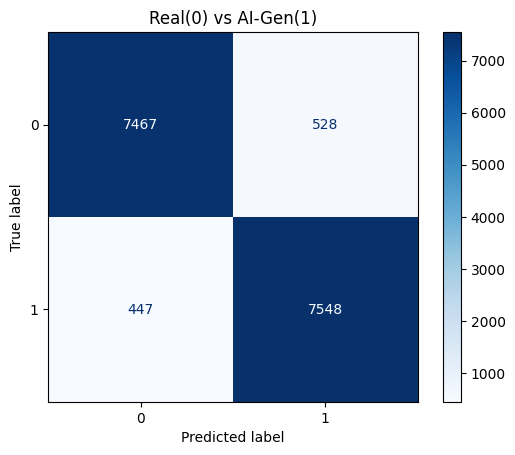

In [ ]:
# Classification Report And Confusion Matrix

y_true = np.concatenate([y for x, y in test_ds], axis = 0)

y_pred_probs = simple_model.predict(test_ds)

y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "Blues")
disp.ax_.set_title("Real(0) vs AI-Gen(1)")

# Classification Report
print(classification_report(y_true, y_pred, target_names = ["Real", "AI-Gen"]))

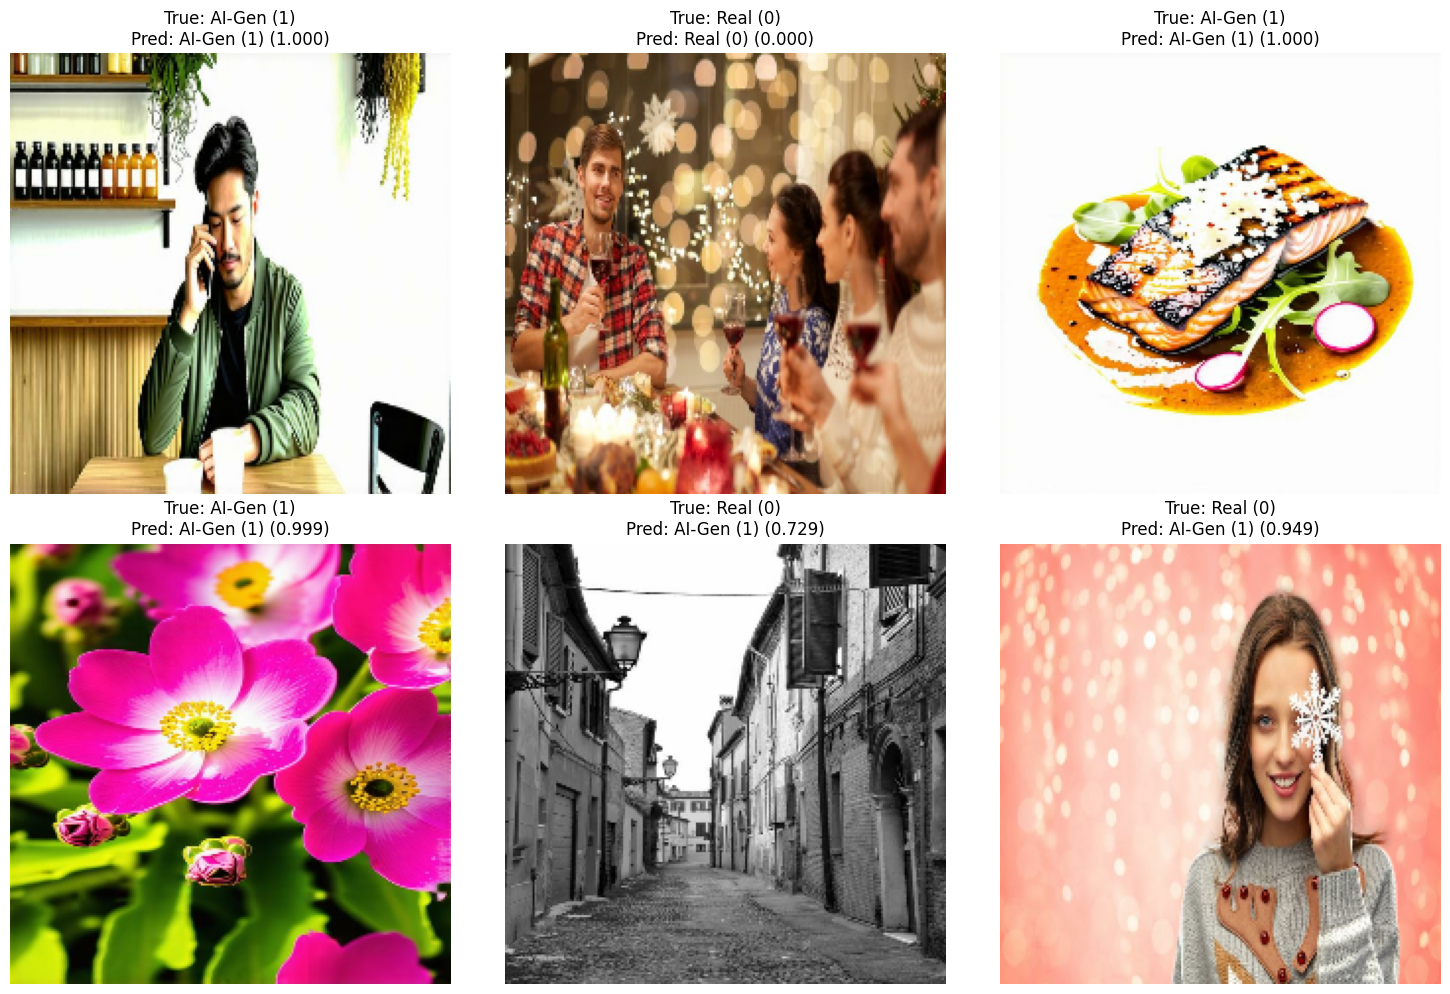

In [ ]:
images_batch, labels_batch = next(iter(test_ds.unbatch().batch(6)))

# Make predictions
predictions = simple_model.predict(images_batch, verbose=0)

# Create 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(6):
    img = images_batch[idx].numpy()
    # Clip values to [0, 1] range (in case of any preprocessing)
    img = np.clip(img, 0, 1)

    true_label = int(labels_batch[idx].numpy())
    pred_value = predictions[idx][0]
    pred_label = 1 if pred_value >= 0.5 else 0

    # Display image (already in [0, 1] range)
    axes[idx].imshow(img)
    axes[idx].axis('off')

    # Create title with prediction and ground truth
    true_class = "AI-Gen (1)" if true_label == 1 else "Real (0)"
    pred_class = "AI-Gen (1)" if pred_label == 1 else "Real (0)"

    title = f'True: {true_class}\nPred: {pred_class} ({pred_value:.3f})'
    axes[idx].set_title(title, fontsize=12)

plt.tight_layout()
plt.show()

Random image selected: /kaggle/input/ai-vs-human-generated-dataset/train_data/7a001572313543628b132fee94b86db1.jpg


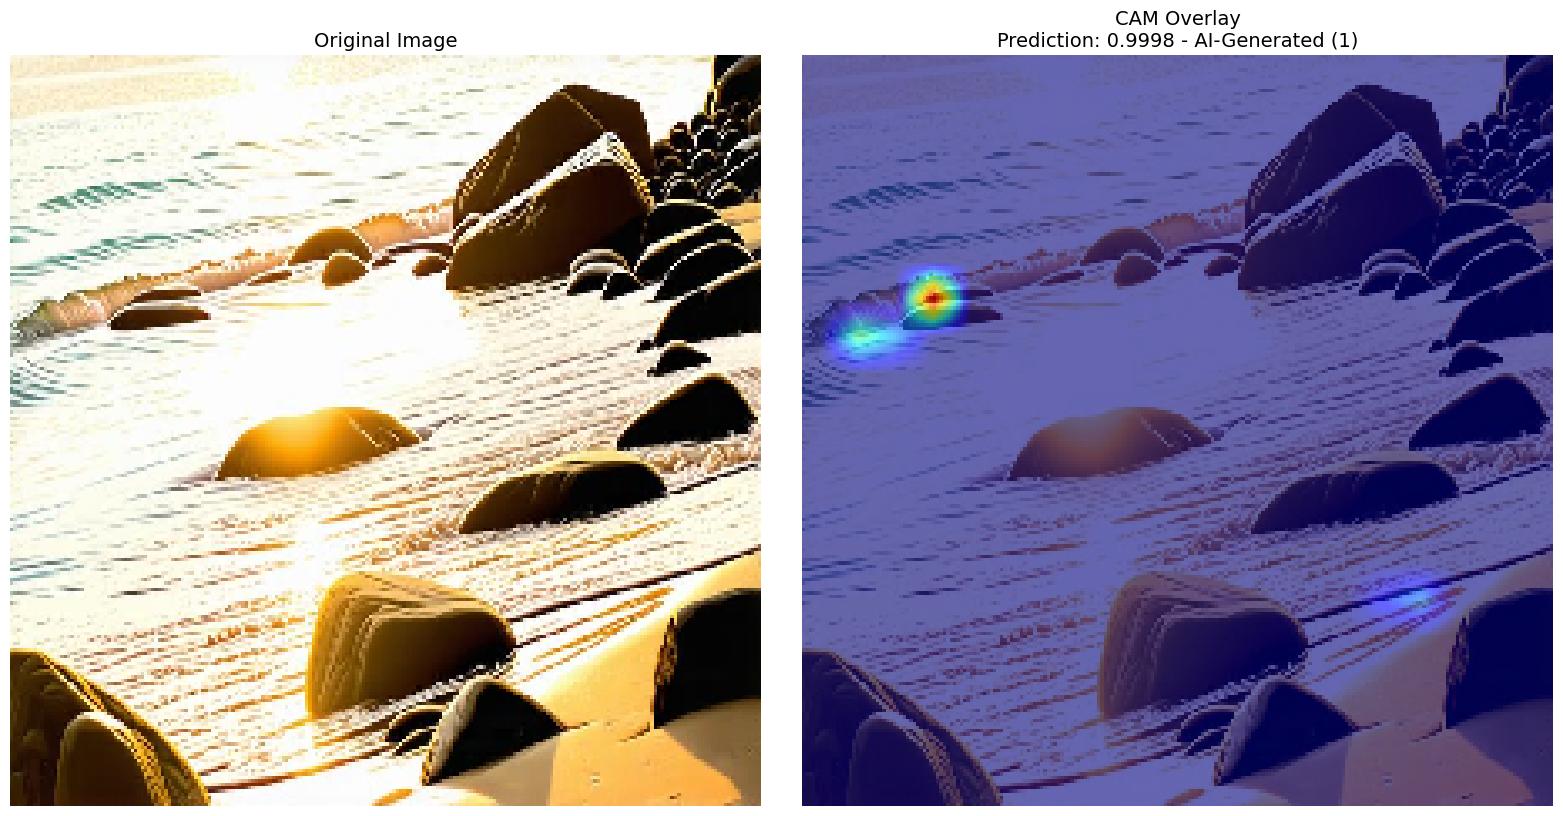

In [ ]:
def show_grad_cam(img_path, model, alpha=0.6):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)

    # Find the last conv layer and get its index
    last_conv_idx = None
    last_conv_layer = None
    for idx, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_idx = idx
            last_conv_layer = layer

    if last_conv_layer is None:
        print("Error: No Conv2D layer found in model")
        return

    # Create a new model up to the last conv layer
    feature_model = tf.keras.Sequential(model.layers[:last_conv_idx+1])

    # Get the feature maps
    feature_maps = feature_model.predict(img_array, verbose=0)

    # Get prediction from full model
    prediction = model.predict(img_array, verbose=0)[0][0]

    # Find the first Dense layer after GlobalAveragePooling2D
    gap_found = False
    dense_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
            gap_found = True
        elif gap_found and isinstance(layer, tf.keras.layers.Dense):
            dense_layer = layer
            break

    if dense_layer is None:
        print("Error: No Dense layer found after GlobalAveragePooling2D")
        return

    # Get weights for the output class (binary classification - use first neuron weights)
    weights = dense_layer.get_weights()[0][:, 0]  # Shape: (num_filters,)

    # Generate CAM by weighted sum of feature maps
    feature_maps = feature_maps[0]  # Remove batch dimension
    cam = np.zeros(feature_maps.shape[:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * feature_maps[:, :, i]

    # Apply ReLU and normalize
    cam = np.maximum(cam, 0)
    if np.max(cam) != 0:
        cam = cam / np.max(cam)

    # Resize CAM to image size
    cam = cv2.resize(cam, (224, 224))

    # Create heatmap
    heatmap = plt.cm.jet(cam)[:, :, :3]

    # Normalize original image
    img_np = np.array(img) / 255.0

    # Overlay heatmap on image
    overlay = heatmap * alpha + img_np * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=14)
    axes[0].axis('off')

    # Determine predicted class
    predicted_class = "AI-Generated (1)" if prediction >= 0.5 else "Real (0)"

    axes[1].imshow(overlay)
    axes[1].set_title(f'CAM Overlay\nPrediction: {prediction:.4f} - {predicted_class}', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

new_path = path + "/train_data"
all_images = [os.path.join(new_path, f) for f in os.listdir(new_path) if f.endswith((".jpg", ".png"))]
img_path = random.choice(all_images)
print("Random image selected:", img_path)

show_grad_cam(img_path, simple_model)


In [ ]:
# Chameleon Benchmark

# !wget -O Chameleon.zip https://www.dropbox.com/scl/fi/auujmqk4wk3um0qk83qy9/Chameleon.zip?rlkey=2xtl34s33uce0fa3yb2zf4rqw&st=ftfnd8op&dl=0
# !unzip Chameleon.zip


In [ ]:
# Load Simple Model

simple_model = tf.keras.models.load_model("/content/drive/My Drive/models/simple_model.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/My Drive/simple_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)